# Machine Learning for Land Models (ML4Land)

This notebook describes how to construct a ML based land model for use in climate modelling.

It is intended as a simple toy example to explore how to obtain and process data from different sources, and then bring this data into a simple ML pipeline.

## Overview

* We will be using a Random Forest regressor to map features to outputs, $x \rightarrow y$

* The features are obtained from the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=overview).

* The outputs, for the purposes of this notebook, are just the Land surface temperature which we get from [MODIS](https://modis-land.gsfc.nasa.gov/temp.html).

# Table of Contents
0. [Define some useful functions](#functions)
1. [Getting the X data](#features)
2. [Getting the Y data](#ydata)
3. [Clean and combine the data](#clean)
4. [Do some simple ML](#ML)


---


## 0. Define some useful functions <a name="functions"></a>

First we can import some modules that will be useful, and define a general plotting function

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import rioxarray as rxr

def plotit(df,x):
    
    #Pass a df object, convert to xarray object f and the value to plot x
    
    
    #f = xr.Dataset.from_dataframe(df)
    
    
    fig = plt.figure(figsize=[24,12])
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))

    #f[x].plot(ax=ax, 
     #         cmap='jet',
      #        transform=ccrs.PlateCarree())
    ax.coastlines()


    plt.show()

## 1. Getting the X data <a name="features"></a>

As discussed, we will get our features via the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=overview).

In particular, we will use the ERA5-Land monthly averaged data, which ranges from 1981 to present.

We will access this data via the [climetlab](https://climetlab.readthedocs.io/en/latest/index.html) package, which in turn uses the [CDS API](https://pypi.org/project/cdsapi/)

We can select the variables we are interested in and also the relevant time range.

For now, lets just get the 2m temperature, and the u/v 10m temperature wind components for January 2016.

In [3]:
import climetlab as cml

variables = ['2m_temperature','10m_u_component_of_wind', '10m_v_component_of_wind'] #Variables we are interested in

#Time selection
years = ['2016']
months = ['01']
times= ["00:00"]


#Load the data

load_from_remote = False

if load_from_remote:
    xdata = cml.load_source("cds",
                            "reanalysis-era5-land-monthly-means",
                             variable=variables,
                             product_type= "monthly_averaged_reanalysis",
                             year = years,
                             month = months,
                             time = times
                             )
    cds_xarray = xdata.to_xarray(backend_kwargs={'errors': 'ignore','filter_by_keys':{'edition': 1, 'typeOfLevel':'surface'}})
else:
    cds_xarray = xr.open_dataset('../data/xdata.grib', engine='cfgrib')

Ignoring index file '../data/xdata.grib.923a8.idx' incompatible with GRIB file


In [4]:
cds_xarray

<xarray.Dataset>
Dimensions:     (latitude: 1801, longitude: 3600)
Coordinates:
    number      int64 ...
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude   (longitude) float64 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
    valid_time  datetime64[ns] ...
Data variables:
    t2m         (latitude, longitude) float32 ...
    u10         (latitude, longitude) float32 ...
    v10         (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-10-29T12:24 GRIB to CDM+CF via cfgrib-0.9.9...

In [5]:
cds_xarray.to_dataframe()


number       time   step  surface valid_time         t2m  \
latitude longitude                                                             
 90.0    0.0             0 2016-01-01 1 days      0.0 2016-01-02         NaN   
         0.1             0 2016-01-01 1 days      0.0 2016-01-02         NaN   
         0.2             0 2016-01-01 1 days      0.0 2016-01-02         NaN   
         0.3             0 2016-01-01 1 days      0.0 2016-01-02         NaN   
         0.4             0 2016-01-01 1 days      0.0 2016-01-02         NaN   
...                    ...        ...    ...      ...        ...         ...   
-90.0    359.5           0 2016-01-01 1 days      0.0 2016-01-02  241.588226   
         359.6           0 2016-01-01 1 days      0.0 2016-01-02  241.588226   
         359.7           0 2016-01-01 1 days      0.0 2016-01-02  241.588226   
         359.8           0 2016-01-01 1 days      0.0 2016-01-02  241.588226   
         359.9           0 2016-01-01 1 days      0.0 2016-01-02  241.588226   

                        u10       v10  
latitude longitude                     
 90.0    0.0            NaN       NaN  
         0.1            NaN       NaN  
         0.2            NaN       NaN  
         0.3            NaN       NaN  
         0.4            NaN       NaN  
...                     ...       ...  
-90.0    359.5      1.08313  2.439671  
         359.6      1.08313  2.439671  
         359.7      1.08313  2.439671  
         359.8      1.08313  2.439671  
         359.9      1.08313  2.439671  

[6483600 rows x 8 columns]

In [ ]:
plotit(cds_xarray.to_dataframe(),'t2m')

In [1]:
fig = plt.figure(figsize=[24,12])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
ax.coastlines()
plt.show()

NameError: name 'plt' is not defined

Since a remote query _can_ take quite a long time depending on the request, it can be useful to just open directly from a pre-downloaded file, also using `xarray`. Use the `load_from_remote` flag accordingly





Now we have the data, lets take a quick look. Note that the variable strings that we used in the API call are different (but equivalent!) to the data column names: 

In [ ]:
vars_list = list(cds_xarray.keys())
for v in vars_list:
    print (v)
    plotit(cds_xarray.to_dataframe(),v)


t2m


## 2. Getting the Y data <a name="ydata"></a>

For our outputs or `Y`-data, we will use LST values from [MODIS](https://modis-land.gsfc.nasa.gov/temp.html).

In particular we will use the CMG (Climate Modelling Grid) product on a monthly timescale [MOD11C3](https://lpdaac.usgs.gov/products/mod11c3v006/)

We can access this MODIS data via HTTPS queries of the [Data Pool](https://lpdaac.usgs.gov/tools/data-pool/). [See the docs](https://lpdaac.usgs.gov/resources/e-learning/how-access-lp-daac-data-command-line/) for a more indepth discussion on how to do this. 

In [6]:

#Uncomment to run
#!wget https://e4ftl01.cr.usgs.gov/MOLT/MOD11C3.006/2016.01.01/MOD11C3.A2016001.006.2016234032549.hdf -O ../data/ydata.hdf

Now lets take a look at this downloaded file:

In [2]:
import xarray as xr
import rioxarray as rxr

modis_xarray= rxr.open_rasterio('../data/ydata.hdf',masked=True)
plotit(modis_xarray.to_dataframe(), 'LST_Day_CMG')



KeyboardInterrupt: 

## 3. Clean and combine the data <a name="clean"></a>

Now lets clean up both datasets and join them together.

Note that in joining the two dfs on lat/long we have introduced a linear shift of 0.025 degrees in the MODIS data coordinates such that coodinates of the form e.g.

-179.975, -179.925, 179.875, ...

become

-180.0, -179.50, -179.0, ...

We can then do an inner join with the CDS data which is spaced on a 0.1 deg resolution, subject to a long1/long3 conversion.

**We should clarify the proper way to deal with this, rather than a simple shift? Perhaps some interpolation method? Tools likely already exist**

In [21]:
#Make everything a pandas df
df_x_orig = cds_xarray.to_dataframe()
df_y_orig = modis_xarray.to_dataframe()

#Create some copies that we will modify, leaving df_x_orig, df_y_orig unaltered in case we need to refer back
df_x = df_x_orig.copy()
df_y = df_y_orig.copy()

In [22]:
import numpy as np
#Reindex dfx to long1
df_x['latitude'] = np.round(df_x.index.get_level_values('latitude').values,3)
df_x['longitude'] = np.round((df_x.index.get_level_values('longitude').values +180) %360 - 180,3)
df_x = df_x.set_index(['latitude', 'longitude'], drop=True)


selected_x_columns = ['t2m','u10','v10'] #only use these columns, drop the others
df_x = df_x[selected_x_columns]

#Reindex dfy via a linear shift
#---ATTENTION---!> We add a linear shift of 0.0250 such that the coordinates match between the X and Y data
# We need to clarify the proper way to deal with this. Perhaps some interpolation method?
df_y['latitude'] = np.round(df_y.index.get_level_values('y').values,3) - 0.0250
df_y['longitude'] = np.round(df_y.index.get_level_values('x').values,3) - 0.0250
df_y = df_y.set_index(['latitude', 'longitude'], drop=True)

selected_y_columns = ['LST_Day_CMG'] #only use these columns, drop the others
df_y = df_y[selected_y_columns]





In [31]:
df_ML = df_y.merge(df_x, how = 'inner', left_index=True, right_index=True) #Merge
df_ML_clean = df_ML.dropna() #Get rid of nulls

There is a curious effect whereby apparent artifacts are introduced in the plotting when dropping Nulls. Consider the `'LST_Day_CMG'` map for `df_ML` and then once we drop the nulls:

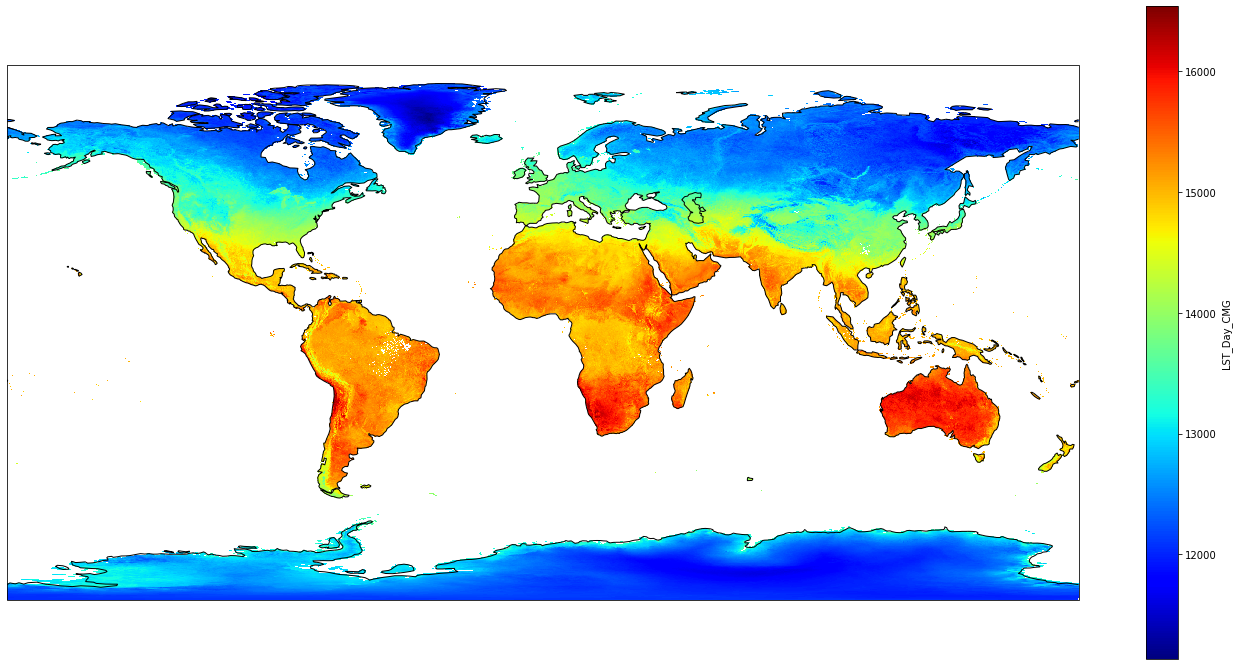

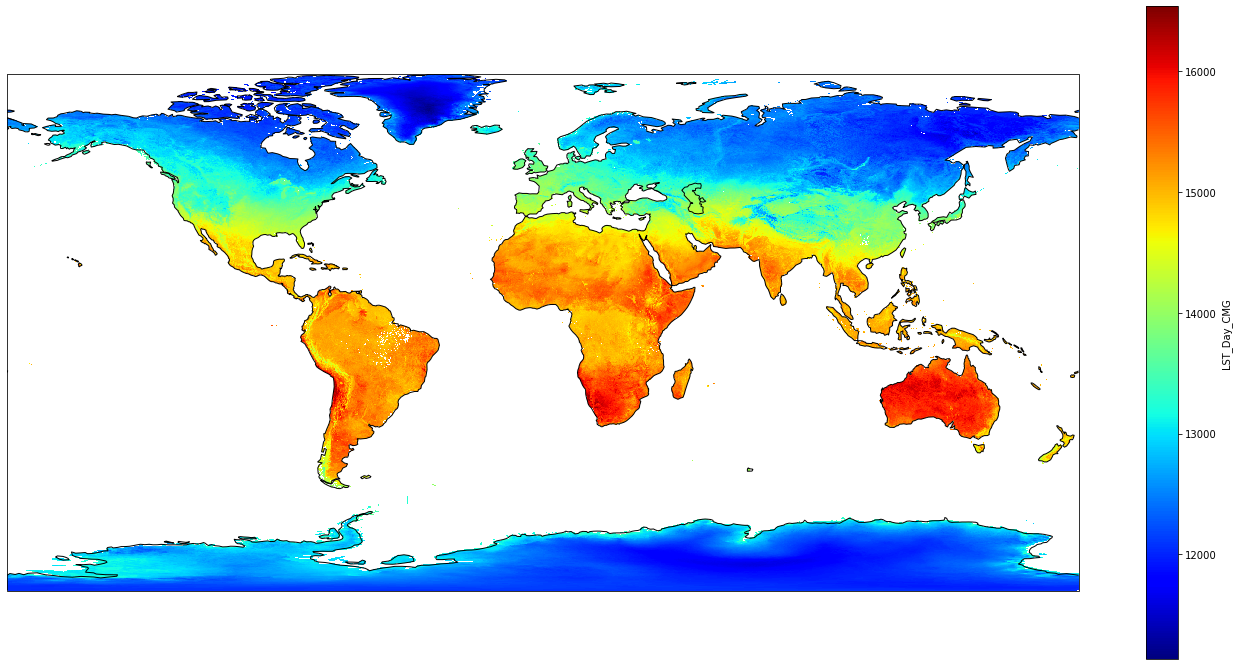

In [32]:
plotit(df_ML,'LST_Day_CMG')
plotit(df_ML_clean,'LST_Day_CMG')

There seems to be some artifact, evident in a small vertical line off the coast of South America. **Need to establish exactly what is causing this**. As far as I can tell it is a _plotting_ issue rather than an issue with the data processing itself, but need to confirm this.

Going forward we will adopt `df_ML_clean` for our analysis.

In [33]:
display(df_ML_clean)

LST_Day_CMG         t2m       u10       v10
latitude longitude                                             
 83.5    -36.6          12274.0  249.203461  0.042114  1.999729
         -36.5          12274.0  249.203461  0.042114  1.999729
         -36.4          12274.0  249.203461  0.042114  1.999729
         -36.3          12270.0  249.203461  0.042114  1.999729
         -36.1          12270.0  249.203461  0.042114  1.999729
...                         ...         ...       ...       ...
-90.0     171.2         12090.0  241.588226  1.083130  2.439671
          171.4         12090.0  241.588226  1.083130  2.439671
          171.5         12090.0  241.588226  1.083130  2.439671
          171.6         12090.0  241.588226  1.083130  2.439671
          171.7         12090.0  241.588226  1.083130  2.439671

[995326 rows x 4 columns]

## 4. Do some simple ML <a name="ML"></a>

We now have all the data in a single df `df_ML_clean`

Lets do some ML with this data.

First it is actually useful to split up the df we just created (!) into two reduced x/y dfs:

In [34]:
x = df_ML_clean.drop(columns=['LST_Day_CMG']) #all the other columns. Don't use long3 - just for join
y = df_ML_clean[['LST_Day_CMG']] #just the 'y' column

display(x)
display(y)

t2m       u10       v10
latitude longitude                                
 83.5    -36.6      249.203461  0.042114  1.999729
         -36.5      249.203461  0.042114  1.999729
         -36.4      249.203461  0.042114  1.999729
         -36.3      249.203461  0.042114  1.999729
         -36.1      249.203461  0.042114  1.999729
...                        ...       ...       ...
-90.0     171.2     241.588226  1.083130  2.439671
          171.4     241.588226  1.083130  2.439671
          171.5     241.588226  1.083130  2.439671
          171.6     241.588226  1.083130  2.439671
          171.7     241.588226  1.083130  2.439671

[995326 rows x 3 columns]

LST_Day_CMG
latitude longitude             
 83.5    -36.6          12274.0
         -36.5          12274.0
         -36.4          12274.0
         -36.3          12270.0
         -36.1          12270.0
...                         ...
-90.0     171.2         12090.0
          171.4         12090.0
          171.5         12090.0
          171.6         12090.0
          171.7         12090.0

[995326 rows x 1 columns]

Now lets create a training and test set:

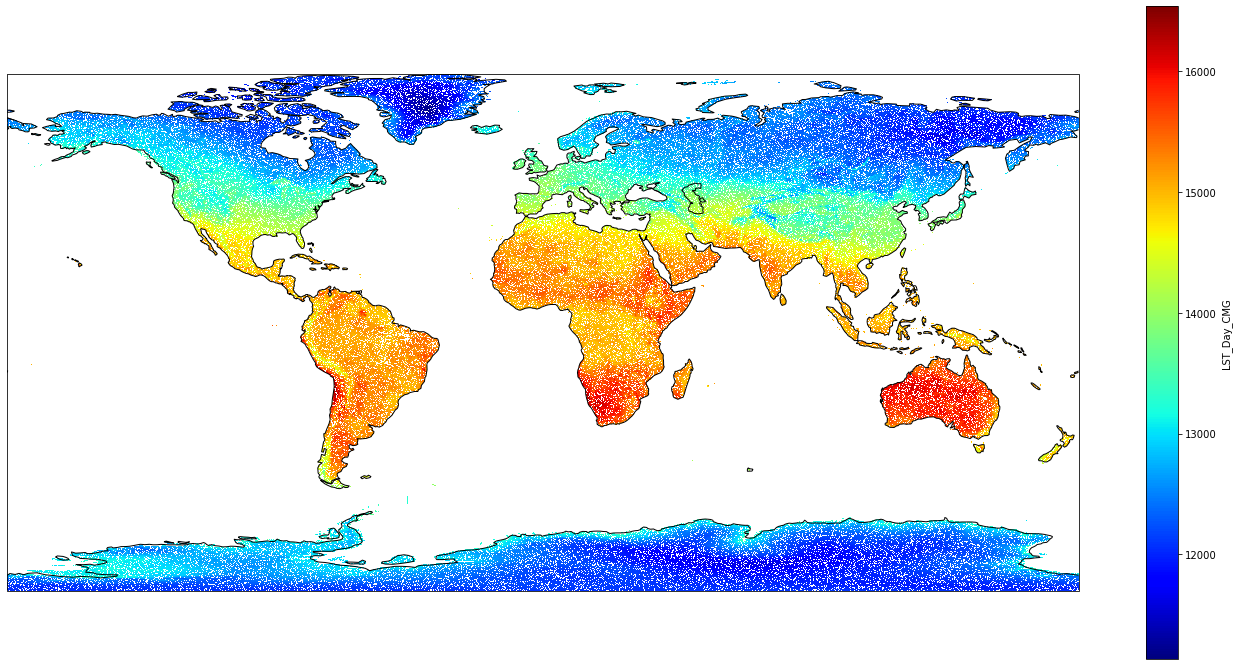

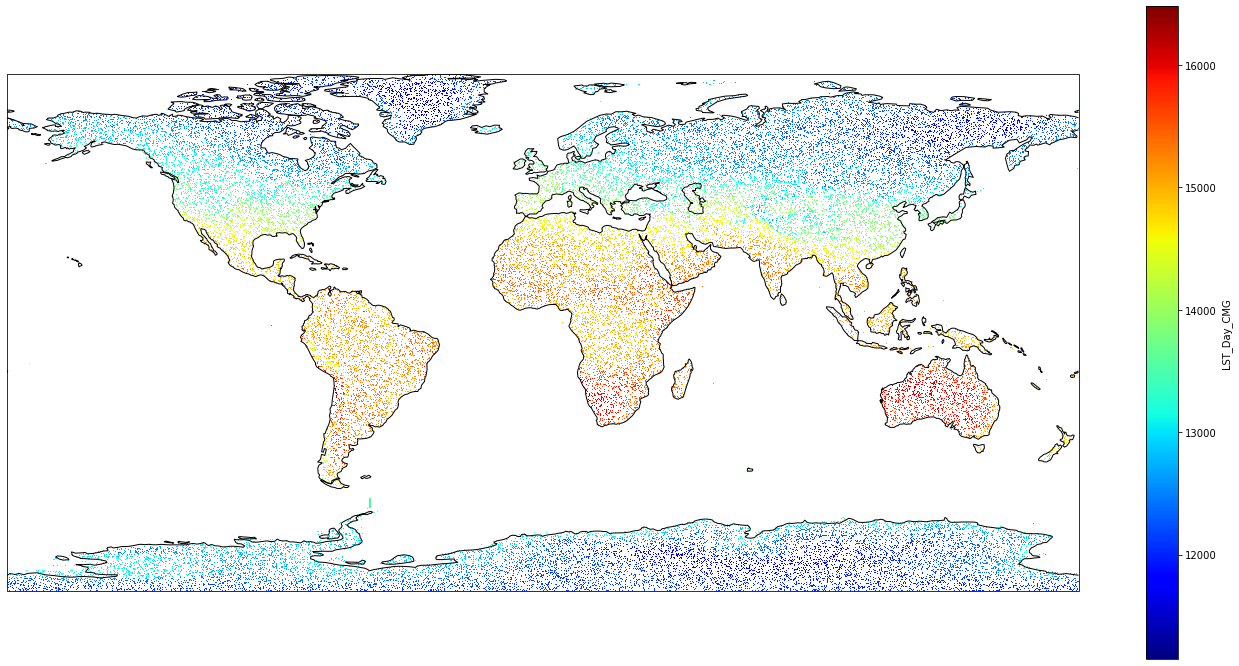

In [35]:
from sklearn.model_selection import train_test_split

#Create train/test data
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20)

#Create two dfs holding the test/train data
df_train = x_train.merge(y_train, how = 'inner', on=['latitude', 'longitude']) 
df_test = x_test.merge(y_test, how = 'inner', on=['latitude', 'longitude']) 

#Plot the train and test data
plotit(df_train,'LST_Day_CMG')
plotit(df_test,'LST_Day_CMG')

**Note again the vertical artifacts near the tip of S. America...**


...and now train using an RF 

In [36]:
from sklearn.ensemble import RandomForestRegressor


#Make everything numpy arrays
x_train = x_train.to_numpy()
y_train = y_train.to_numpy().ravel() #flatten

x_test = x_test.to_numpy()
y_test = y_test.to_numpy().ravel()


# Initiate model 
rf = RandomForestRegressor(n_estimators = 10, verbose=1)

# Train the model on training data
rf.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   33.3s finished


RandomForestRegressor(n_estimators=10, verbose=1)

With a trained model we can then make some predictions, and then evaluate these predictions againsts the true (test) data

In [37]:
from sklearn.metrics import r2_score

y_pred = rf.predict(x_test)
training_score = rf.score(x_train, y_train)
testing_score = rf.score(x_test, y_test) # =r2_score(y_test, y_pred)
relative_error = (y_pred - y_test)/y_test

print ('Train/Test score:', training_score, testing_score)
print ('Max/min relative error:', max(abs(relative_error)), min(abs(relative_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train/Test score: 0.9962283438788064 0.9783996292964204
Max/min relative error: 0.12698693041328152 0.0


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished


Not too bad! But then we did use the 2m surface temperature...

We can also visualise how this error is spread geographically: 

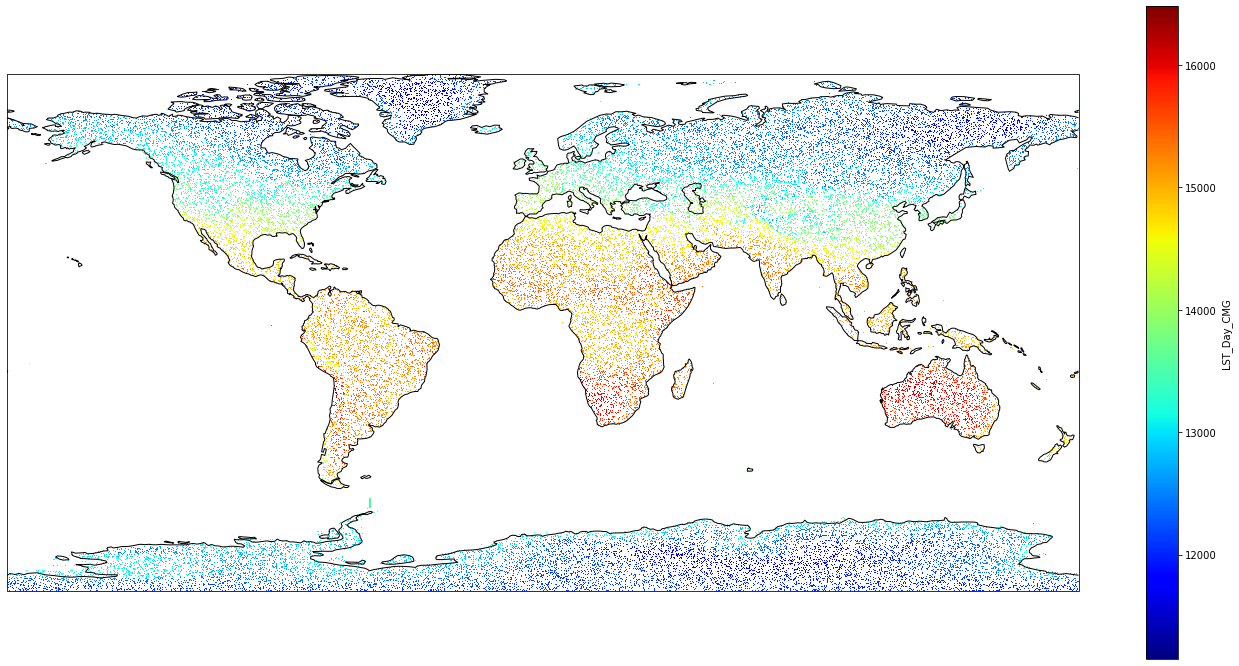

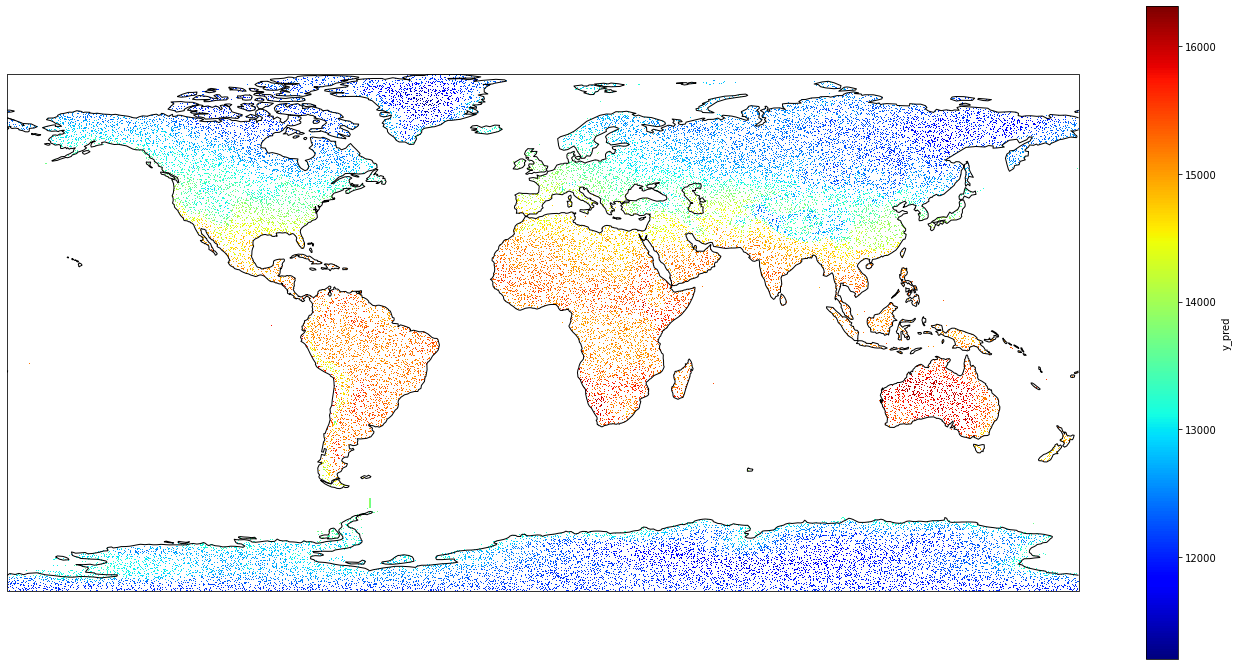

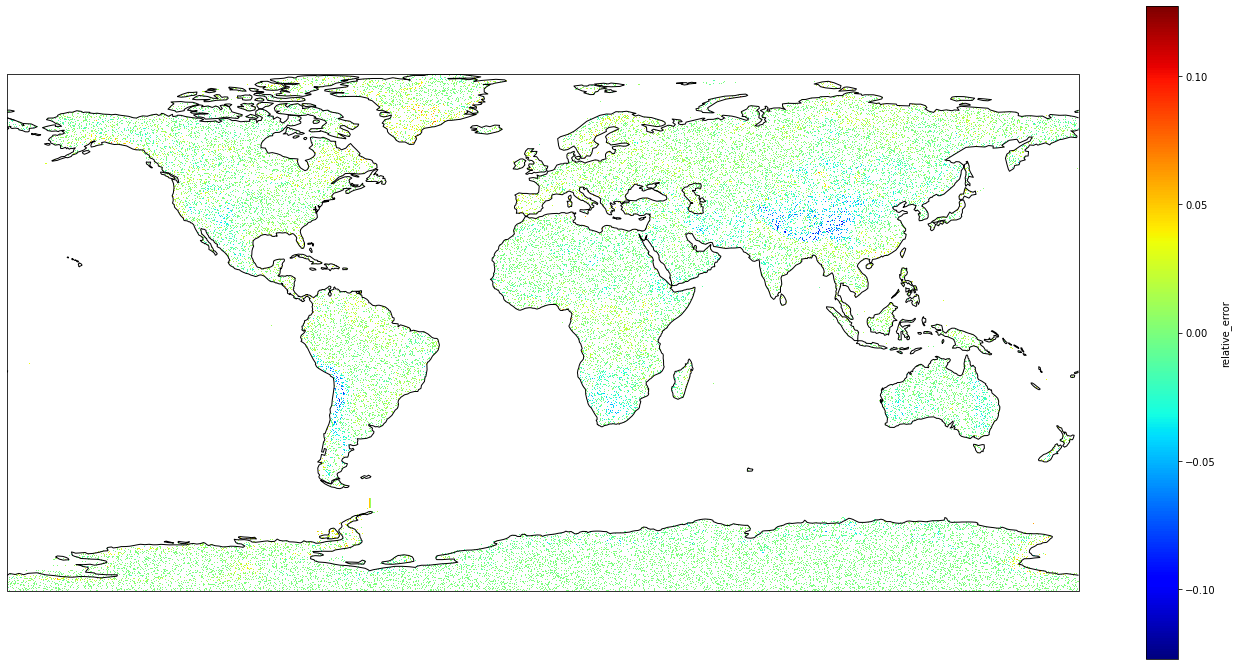

In [38]:
#Add the error and predictions to the test df i
df_test['relative_error'] = relative_error
df_test['y_pred'] = y_pred

#--Plot it up

#Actual
plotit(df_test,'LST_Day_CMG')

#Predicted
plotit(df_test,'y_pred')


#Error
plotit(df_test,'relative_error')

